In [215]:
import pandas as pd
import numpy as np

from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings


from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

#Libary for Autoregressive model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

#Plot PACF function
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

#Auto ARIMA for paramanter tuning
#from pmdarima.arima import auto_arima
import pmdarima as pm

#import plotly for interactive graphs
import plotly.express as px 

#import Altar for interactive plots
import altair as alt 

In [216]:
#Display option to see more columns. Usefull to see all the columns of Dummy variables for Machine Learning
pd.set_option('display.max_columns', 120)

#make the charts look better for displays with retina resolution 
%config InlineBackend.figure_format = 'retina'

In [217]:
pd.set_option('display.max_rows', None)

In [218]:
#warnings.filterwarnings("ignore")

### Read in data and basic data processing

#### todo mongodb and full year

In [219]:
GoT_df = pd.read_csv('C:\\data files\\All Clean.csv')

In [220]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status
0,31,turkey_twd,yabancidizilert,mentions,fri jan 01 09:02:04 +0000 2016,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True
1,44,irinaforden,j0n_snow,mentions,fri jan 01 09:36:01 +0000 2016,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True
2,69,fantasysite,fantasysite,tweet,fri jan 01 10:57:58 +0000 2016,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False
3,113,alandalustravel,spain,mentions,fri jan 01 14:25:19 +0000 2016,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False
4,118,rockxx1974,rockxx1974,tweet,fri jan 01 14:36:53 +0000 2016,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False


In [221]:
GoT_df.isnull().sum()

Unnamed: 0        0
poster            0
recipient         4
relationship      0
tweet date        0
tweet id          0
tweet             0
hashtags          0
retweet status    0
dtype: int64

In [222]:
#convert to date and get rid of time stamp on date
GoT_df['tweet date'] = pd.to_datetime(GoT_df['tweet date'])
GoT_df['date'] = GoT_df['tweet date'].dt.date


In [223]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status,date
0,31,turkey_twd,yabancidizilert,mentions,2016-01-01 09:02:04+00:00,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True,2016-01-01
1,44,irinaforden,j0n_snow,mentions,2016-01-01 09:36:01+00:00,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True,2016-01-01
2,69,fantasysite,fantasysite,tweet,2016-01-01 10:57:58+00:00,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False,2016-01-01
3,113,alandalustravel,spain,mentions,2016-01-01 14:25:19+00:00,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False,2016-01-01
4,118,rockxx1974,rockxx1974,tweet,2016-01-01 14:36:53+00:00,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False,2016-01-01


In [224]:
missing_dates = GoT_df.copy()

#find any missing dates
missing_dates = missing_dates.set_index('date')
print(pd.date_range(start='2016-01-01', end='2016-12-31').difference(missing_dates.index))


DatetimeIndex(['2016-02-11', '2016-02-12', '2016-02-13', '2016-02-28',
               '2016-02-29', '2016-03-05', '2016-03-06', '2016-03-07',
               '2016-06-03', '2016-06-04', '2016-06-05', '2016-06-06'],
              dtype='datetime64[ns]', freq=None)


In [225]:
GoT_df.head()

,Unnamed: 0,poster,recipient,relationship,tweet date,tweet id,tweet,hashtags,retweet status,date
0,31,turkey_twd,yabancidizilert,mentions,2016-01-01 09:02:04+00:00,682849258714886144,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,"['gameofthrones', 'supernatural', 'thewalkingd...",True,2016-01-01
1,44,irinaforden,j0n_snow,mentions,2016-01-01 09:36:01+00:00,682857802516172800,"rt @j0n_snow: you know nothing, kit harrington...","['jonsnow', 'gameofthrones']",True,2016-01-01
2,69,fantasysite,fantasysite,tweet,2016-01-01 10:57:58+00:00,682878425925746688,#gameofthrones game of thrones brienne of tart...,['gameofthrones'],False,2016-01-01
3,113,alandalustravel,spain,mentions,2016-01-01 14:25:19+00:00,682930607253499904,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...","['didyouknow', 'lawrenceofarabia', 'gameofthro...",False,2016-01-01
4,118,rockxx1974,rockxx1974,tweet,2016-01-01 14:36:53+00:00,682933518113046528,#gameofthrones marathon auf #tntserie. bitte n...,"['gameofthrones', 'tntserie']",False,2016-01-01


In [226]:
# Drop columns. Only interested in tweet text and date
GoT_df.drop(['Unnamed: 0','poster','recipient','relationship','tweet date','tweet id','hashtags','retweet status'], axis=1,inplace=True)

In [227]:
GoT_df.head()

,tweet,date
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01
2,#gameofthrones game of thrones brienne of tart...,2016-01-01
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01


### Basic Sentiment Analysis

In [228]:
analyzer = SentimentIntensityAnalyzer()

GoT_df['polarity'] = GoT_df['tweet'].apply(lambda x: analyzer.polarity_scores(x))
GoT_df.head()

,tweet,date,polarity
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,"{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp..."
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [229]:
# Change df structure to have pos, neg and neu columns
GoT_df = pd.concat(
    [GoT_df.drop(['polarity'], axis=1), 
     GoT_df['polarity'].apply(pd.Series)], axis=1)
GoT_df.head()

,tweet,date,neg,neu,pos,compound
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,0.000,1.000,0.0,0.0000
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,0.187,0.813,0.0,-0.4585
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,0.000,1.000,0.0,0.0000
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,0.000,1.000,0.0,0.0000
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,0.000,1.000,0.0,0.0000


In [230]:
# Change df structure to have sentiment column
GoT_df['sentiment'] = GoT_df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
GoT_df.head()

,tweet,date,neg,neu,pos,compound,sentiment
0,rt @yabancidizilert: Çeyrek final 2. grup\n#ga...,2016-01-01,0.000,1.000,0.0,0.0000,neutral
1,"rt @j0n_snow: you know nothing, kit harrington...",2016-01-01,0.187,0.813,0.0,-0.4585,negative
2,#gameofthrones game of thrones brienne of tart...,2016-01-01,0.000,1.000,0.0,0.0000,neutral
3,"rt @spain ""#didyouknow #lawrenceofarabia &amp;...",2016-01-01,0.000,1.000,0.0,0.0000,neutral
4,#gameofthrones marathon auf #tntserie. bitte n...,2016-01-01,0.000,1.000,0.0,0.0000,neutral


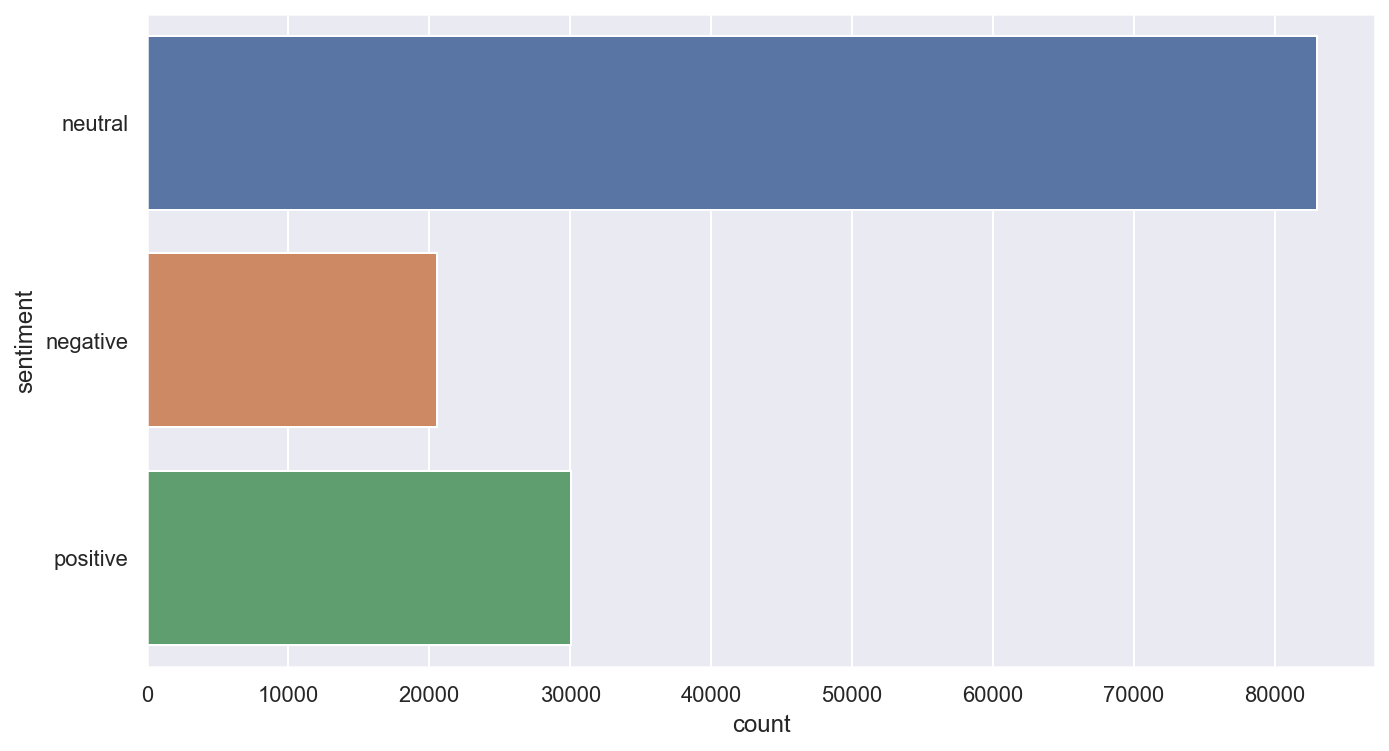

In [231]:
# Number of tweets per sentiment
sns.countplot(y='sentiment', 
             data=GoT_df, 
             );

In [232]:
#Fing how mant of each
print(GoT_df['sentiment'].value_counts()['positive'])
print(GoT_df['sentiment'].value_counts()['negative'])
print(GoT_df['sentiment'].value_counts()['neutral'])

30059
20564
82962


In [233]:
# Drop columns. Only interested in sentiment and date
GoT_df.drop(['tweet','neg','neu','pos','compound'], axis=1,inplace=True)
GoT_df.head()

,date,sentiment
0,2016-01-01,neutral
1,2016-01-01,negative
2,2016-01-01,neutral
3,2016-01-01,neutral
4,2016-01-01,neutral


In [234]:
# Get 2 dataframes for pos, neg 
# Will not be interested in neu
GoT_positive = GoT_df.loc[GoT_df['sentiment'] == 'positive']
GoT_negative = GoT_df.loc[GoT_df['sentiment'] == 'negative']

In [235]:
GoT_positive.head(91)

,date,sentiment
5,2016-01-01,positive
6,2016-01-01,positive
8,2016-01-01,positive
10,2016-01-01,positive
15,2016-01-01,positive
16,2016-01-01,positive
22,2016-01-01,positive
23,2016-01-02,positive
26,2016-01-02,positive
33,2016-01-02,positive


In [236]:
pos = GoT_positive.groupby('date', as_index=False).count()
neg = GoT_negative.groupby('date', as_index=False).count()

In [237]:
pos.shape

(354, 2)

In [238]:
pos.head(400)

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
5,2016-01-06,18
6,2016-01-07,12
7,2016-01-08,18
8,2016-01-09,13
9,2016-01-10,4


#### Missing Data

In [239]:
# Add in missing dates into the dataframe with 0 as sentiment values

pos = pos.set_index('date')
neg = neg.set_index('date')

# Date Range
idx = pd.date_range('01-01-2016', '12-31-2016')

#reindex with 0 in sentiment values
pos = pos.reindex(idx, fill_value=0)
neg = neg.reindex(idx, fill_value=0)

#reset index to sequence
pos = pos.rename_axis('date').reset_index()
neg = neg.rename_axis('date').reset_index()

In [240]:
pos.head(400)

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
5,2016-01-06,18
6,2016-01-07,12
7,2016-01-08,18
8,2016-01-09,13
9,2016-01-10,4


In [241]:
neg.head(400)

,date,sentiment
0,2016-01-01,2
1,2016-01-02,12
2,2016-01-03,5
3,2016-01-04,9
4,2016-01-05,4
5,2016-01-06,5
6,2016-01-07,7
7,2016-01-08,4
8,2016-01-09,4
9,2016-01-10,3


In [242]:
#replace 0's with previous value
pos['sentiment'] = pos['sentiment'].replace(to_replace=0, method='ffill')
neg['sentiment'] = neg['sentiment'].replace(to_replace=0, method='ffill')

In [243]:
#for viewing dates replace with average of viewing date week behind
# 03-June replace with 27-may
# 04-June replace with 28-may
# 05-June replace with 29-may
# 06-June replace with 30-may

pos.at[154, 'sentiment'] = 82
pos.at[155, 'sentiment'] = 90
pos.at[156, 'sentiment'] = 179
pos.at[157, 'sentiment'] = 739

neg.at[154, 'sentiment'] = 42
neg.at[155, 'sentiment'] = 43
neg.at[156, 'sentiment'] = 79
neg.at[157, 'sentiment'] = 603

In [244]:
#pos.loc[62.5] = ['2016-06-03', 64]
#pos.loc[62.6] = ['2016-06-04', 77]
#pos.loc[62.7] = ['2016-06-05', 125]
#pos.loc[62.8] = ['2016-06-06', 732]
#pos = pos.sort_index().reset_index(drop=True)

In [245]:
pos.shape

(366, 2)

In [246]:
pos.head(92)

,date,sentiment
0,2016-01-01,7
1,2016-01-02,20
2,2016-01-03,10
3,2016-01-04,9
4,2016-01-05,3
5,2016-01-06,18
6,2016-01-07,12
7,2016-01-08,18
8,2016-01-09,13
9,2016-01-10,4


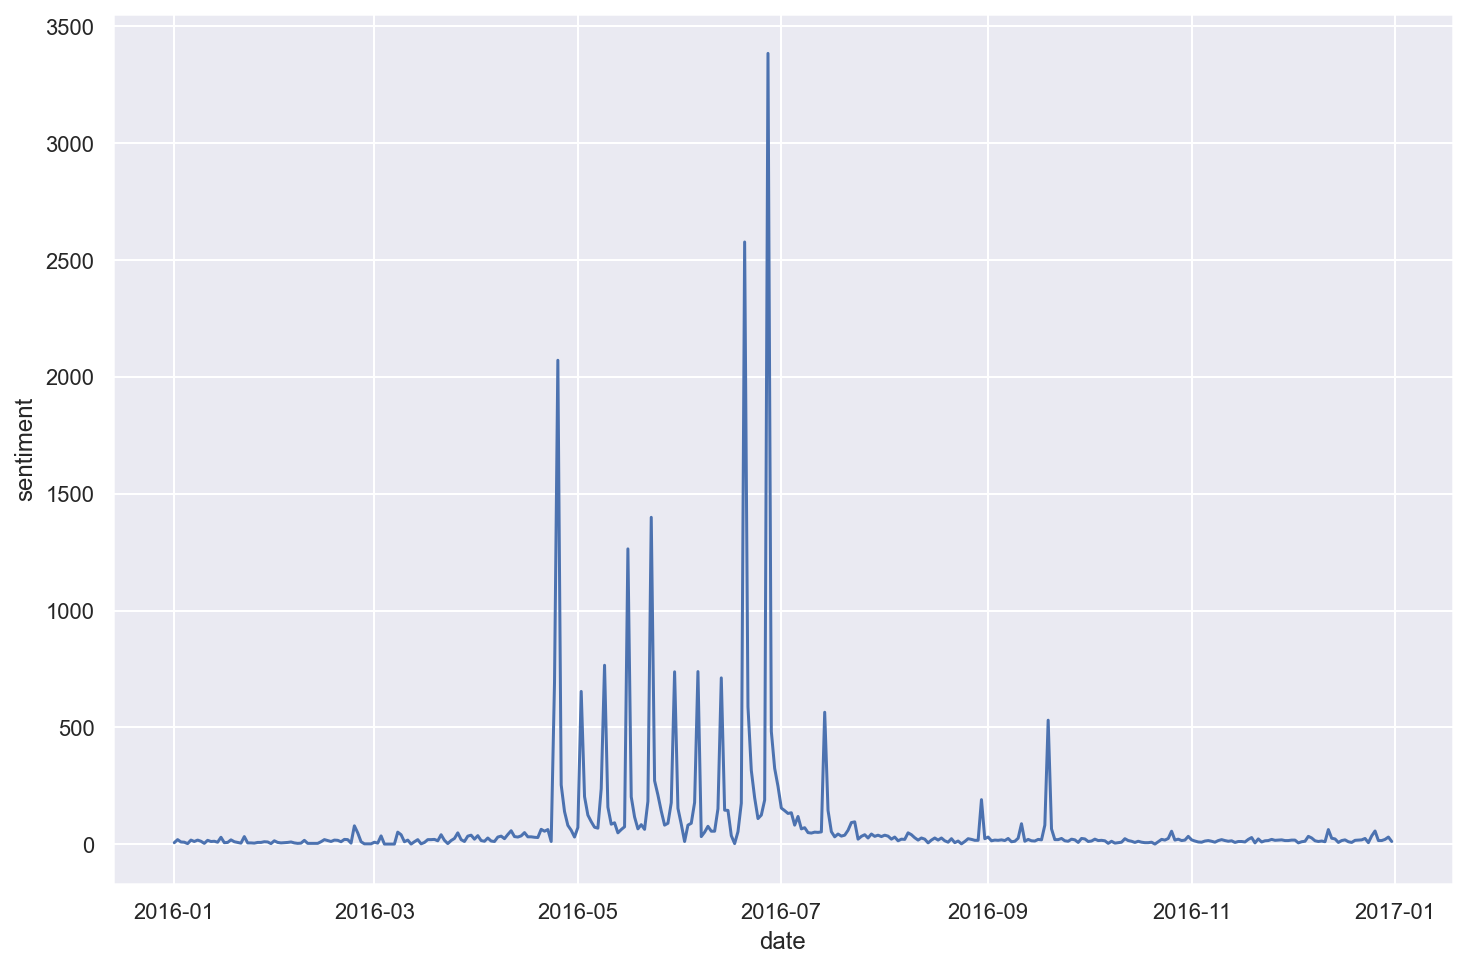

In [247]:
#Graph of positive sentiment over time

sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale=1)
myfig = sns.lineplot(x = 'date', y = 'sentiment', data = pos)
plt.show()

### Time Series

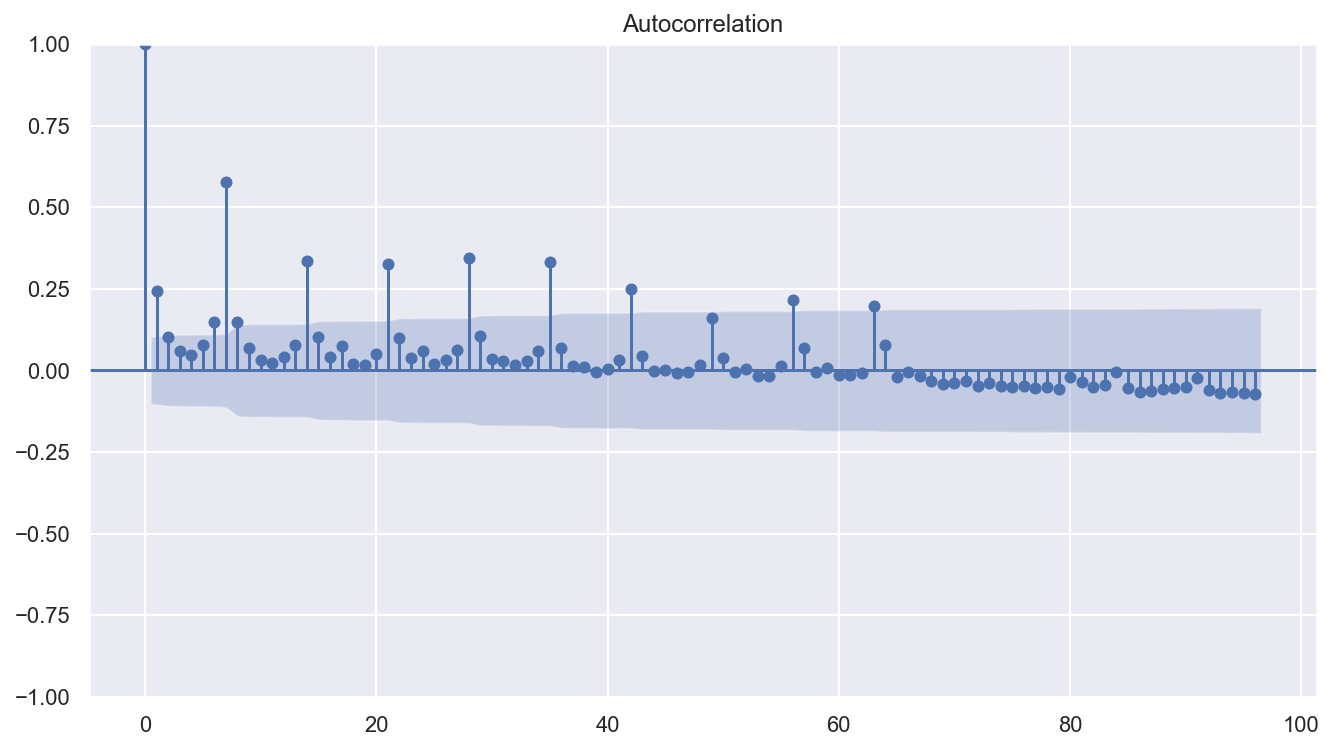

In [248]:
#Plot of Partial Autocorrelation for Positive sentiment
sns.set(rc = {'figure.figsize':(11,6)})
sns.set(font_scale=1)
acf_plot = plot_acf(pos['sentiment'], lags =96)

C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


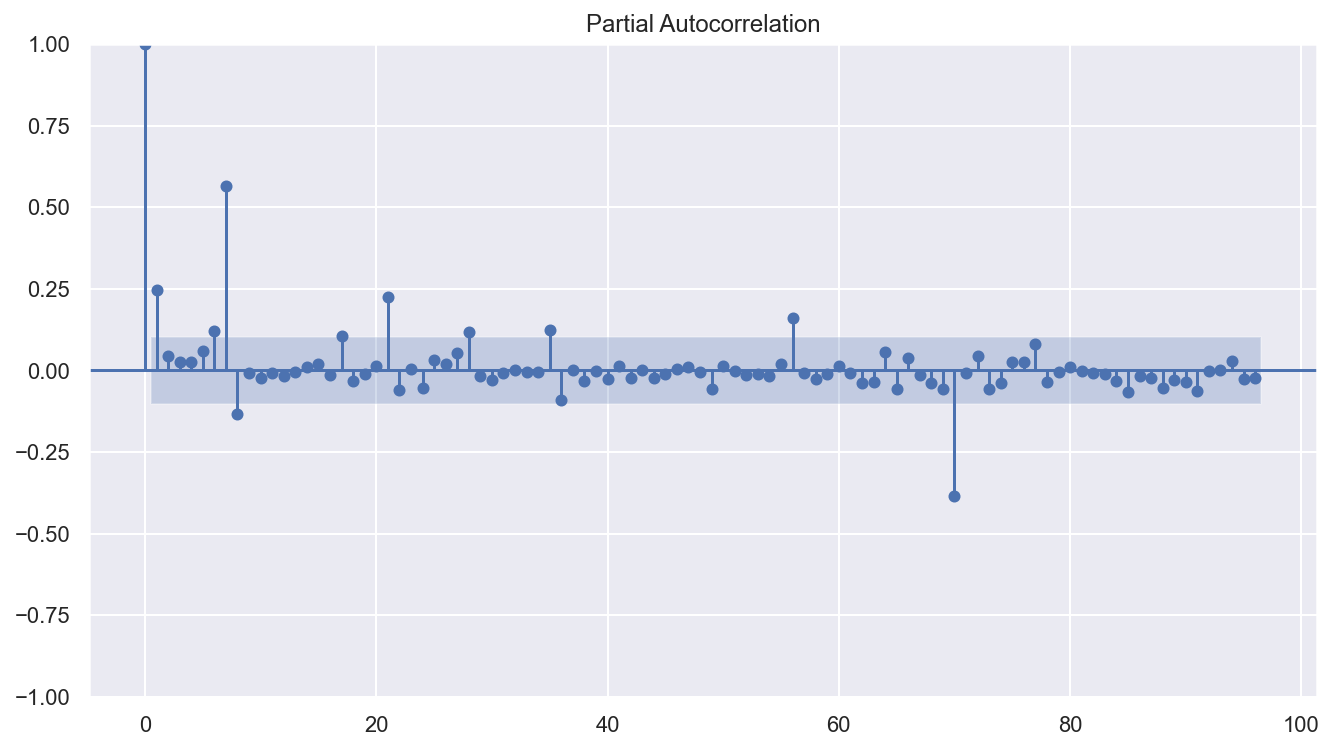

In [249]:
#Plot of Partial Autocorrelation for Positive sentiment
sns.set(rc = {'figure.figsize':(11,6)})
sns.set(font_scale=1)
acf_plot = plot_pacf(pos['sentiment'], lags =96)

#### Autoregression 

In [333]:
#copy pos df
autoregression = pos.copy()

#Drop date column 
autoregression.drop(['date'], axis=1,inplace=True)

#Drop July 1st for now
autoregression= autoregression.drop(labels=[91], axis=0)
autoregression.tail()

,positive
361,16
362,16
363,21
364,31
365,12


In [334]:
#Set the size of the training data and test data. 
#train = autoregression[0:334]
#test = autoregression[335:365]

train = autoregression[0:243]
test = autoregression[244:365]

In [335]:
#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

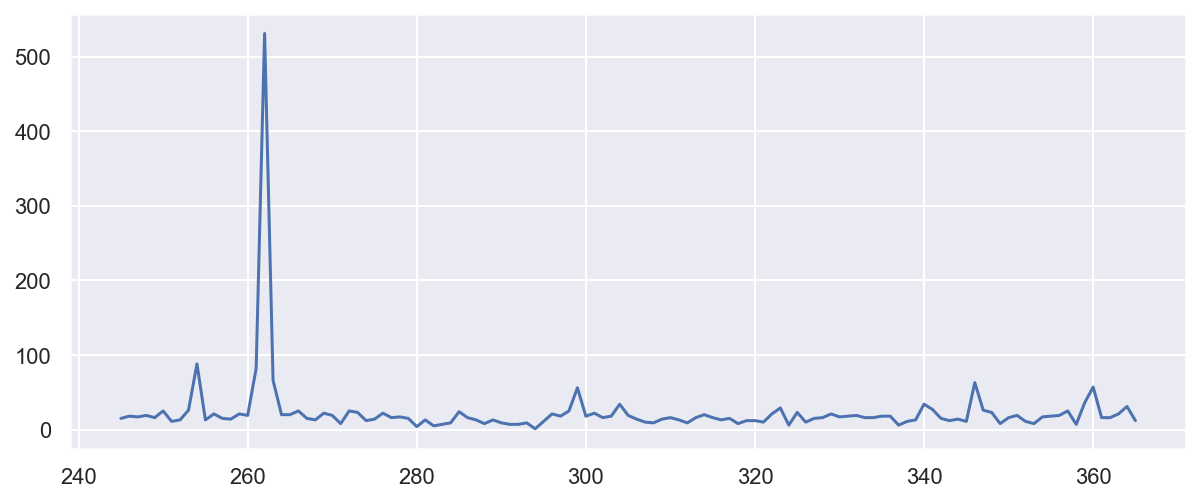

In [336]:
#Plot the test data pattern
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(test)

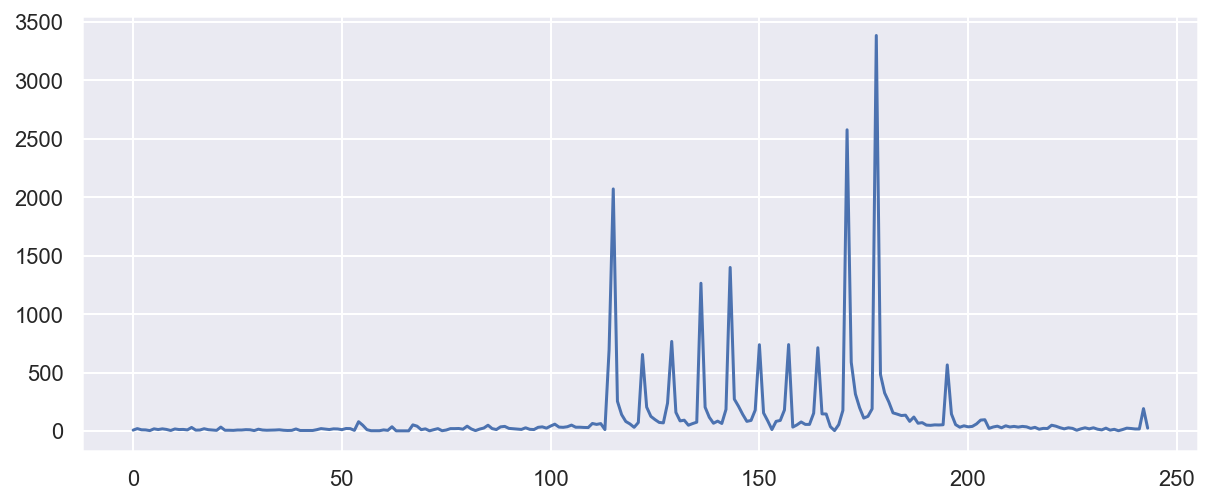

In [337]:
#Plot the training data pattern
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(train)

In [373]:
#Run the AutoReg function with 35 lags
model = AutoReg(train, 35)

#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())



                            AutoReg Model Results                             
Dep. Variable:               positive   No. Observations:                  243
Model:                    AutoReg(35)   Log Likelihood               -1466.217
Method:               Conditional MLE   S.D. of innovations            278.713
Date:                Sat, 13 May 2023   AIC                           3006.435
Time:                        19:12:13   BIC                           3129.924
Sample:                            35   HQIC                          3056.367
                                  243                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           33.9460     28.466      1.193      0.233     -21.846      89.738
positive.L1      0.2360      0.069      3.422      0.001       0.101       0.371
positive.L2      0.0076      0.071      0.10

C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [374]:
#Examine accuracy of model
#Set parameters for start and end predictions
predictionStart = test.index[0]
predictionEnd = test.index[-1]

#Call the model to make predictions
predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

#Difference between test and predictions
residuals = test - predictions

C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tonyw\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


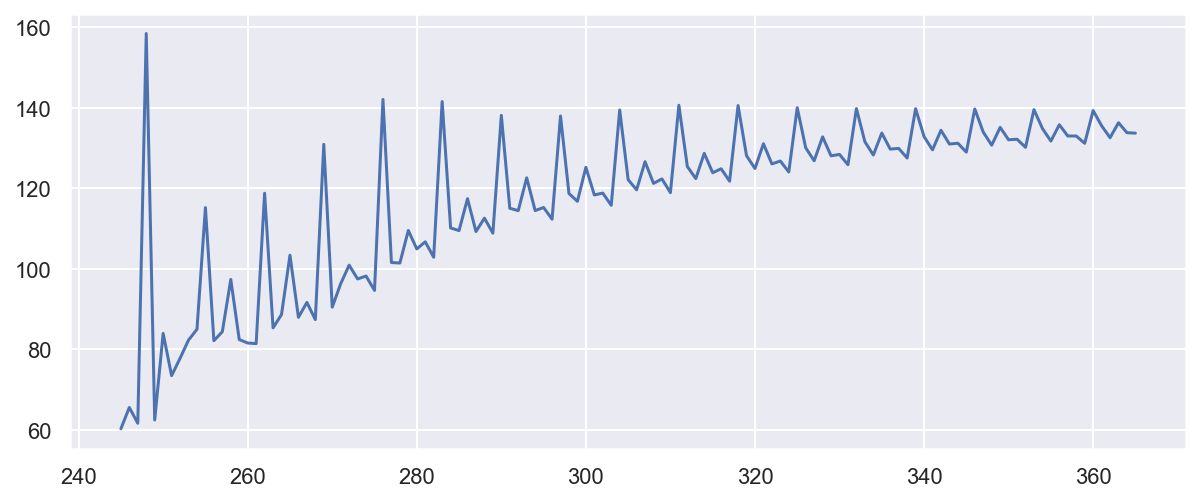

In [375]:
#Plot the pattern of the predictions
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(predictions)

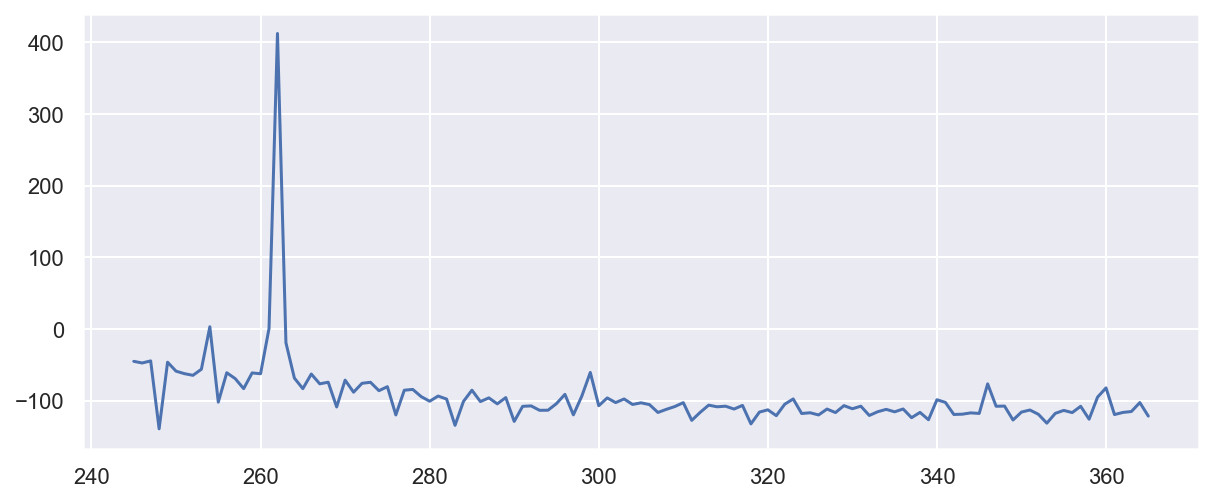

In [376]:
#Plot the pattern of the residuals
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(residuals)

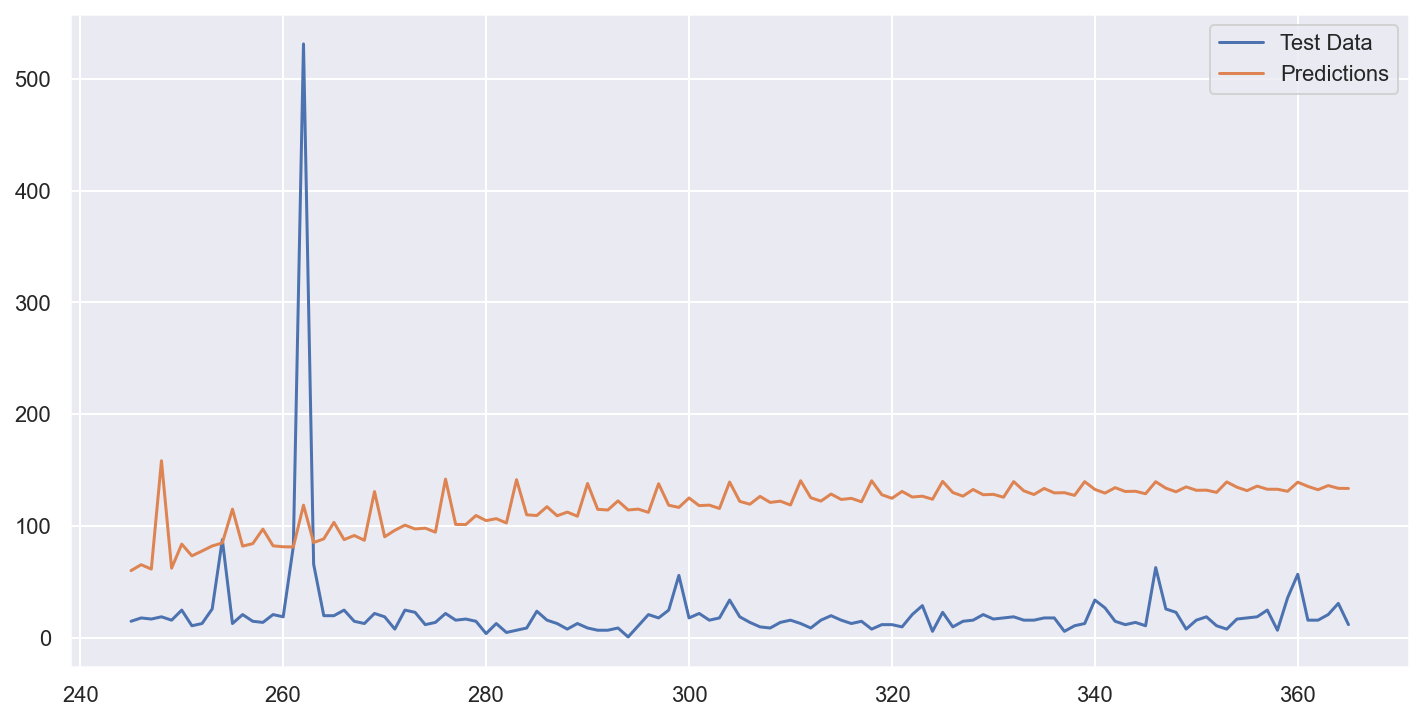

In [377]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

In [378]:
#Calculate Root Mean Squared error
print(f'Root Mean Squared error is: {round(np.sqrt(np.mean(residuals**2)),2)}')

Root Mean Squared error is: 108.04


### Auto ARMA paramaters

In [453]:
#copy pos df
paramaters = pos.copy()

#Drop date column 
paramaters.drop(['date'], axis=1,inplace=True)

#Set the size of the training data and test data. 
#train = paramaters[0:334]
#test = paramaters[335:365]

train = arima[0:275]
test = arima[276:365]

#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

In [454]:
#model = pm.auto_arima(train, trace=True, max_d = 7, max_q = 7, max_p=36, stepwise = False, max_order = 400 ,error_action='ignore', suppress_warnings=True)
model = pm.auto_arima(train, trace=True, max_d = 7, max_q = 7, max_p=22, stepwise = False, max_order = 400 ,error_action='ignore', suppress_warnings=True)

modelFit = model.fit(train)

#Print Model Results
print(modelFit.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3938.340, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3798.895, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3797.518, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3798.989, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=3796.791, Time=0.32 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=3798.586, Time=0.43 sec
 ARIMA(0,1,6)(0,0,0)[1] intercept   : AIC=3795.354, Time=0.44 sec
 ARIMA(0,1,7)(0,0,0)[1] intercept   : AIC=3777.794, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3891.047, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3797.900, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3792.408, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=3794.275, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=3797.824, Time=0.40 sec
 ARIMA(1,1,5)(0,0,0)[1] intercept   : AIC=3789.846, Time=0.43 sec
 ARIMA(1,1,6)(0,0,0)[1] intercept   : AIC=3780.731, Time=0.49 sec
 ARIMA(1,1

 ARIMA(15,1,7)(0,0,0)[1] intercept   : AIC=3722.659, Time=1.71 sec
 ARIMA(16,1,0)(0,0,0)[1] intercept   : AIC=3721.756, Time=0.89 sec
 ARIMA(16,1,1)(0,0,0)[1] intercept   : AIC=3717.259, Time=1.50 sec
 ARIMA(16,1,2)(0,0,0)[1] intercept   : AIC=3718.634, Time=1.61 sec
 ARIMA(16,1,3)(0,0,0)[1] intercept   : AIC=3718.961, Time=1.73 sec
 ARIMA(16,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(16,1,5)(0,0,0)[1] intercept   : AIC=3719.403, Time=2.01 sec
 ARIMA(16,1,6)(0,0,0)[1] intercept   : AIC=3720.728, Time=2.04 sec
 ARIMA(16,1,7)(0,0,0)[1] intercept   : AIC=3726.017, Time=2.21 sec
 ARIMA(17,1,0)(0,0,0)[1] intercept   : AIC=3723.589, Time=1.08 sec
 ARIMA(17,1,1)(0,0,0)[1] intercept   : AIC=3719.047, Time=1.62 sec
 ARIMA(17,1,2)(0,0,0)[1] intercept   : AIC=3720.240, Time=1.86 sec
 ARIMA(17,1,3)(0,0,0)[1] intercept   : AIC=3719.623, Time=2.11 sec
 ARIMA(17,1,4)(0,0,0)[1] intercept   : AIC=3723.275, Time=2.00 sec
 ARIMA(17,1,5)(0,0,0)[1] intercept   : AIC=3721.439, Time=2.02 sec


In [455]:
bla

NameError: name 'bla' is not defined

#### ARIMA

In [456]:
#copy pos df
arima = pos.copy()

#Drop date column 
arima.drop(['date'], axis=1,inplace=True)

#Set the size of the training data and test data. 
#train = arima[0:334]
#test = arima[335:365]

train = arima[0:275]
test = arima[276:365]

#Convert dataframes to a series  
train = train.squeeze()
test = test.squeeze()

In [457]:
model = ARIMA(train, order=(7,1,0))


#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())


                               SARIMAX Results                                
Dep. Variable:               positive   No. Observations:                  275
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -1915.993
Date:                Sat, 13 May 2023   AIC                           3847.986
Time:                        19:35:35   BIC                           3876.891
Sample:                             0   HQIC                          3859.588
                                - 275                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7415      0.050    -14.852      0.000      -0.839      -0.644
ar.L2         -0.6845      0.109     -6.269      0.000      -0.898      -0.470
ar.L3         -0.6323      0.121     -5.244      0.0

In [458]:
#Examine accuracy of model
#Set parameters for start and end predictions
predictionStart = test.index[0]
predictionEnd = test.index[-1]

#Call the model to make predictions
predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

#Difference between test and predictions
residuals = test - predictions

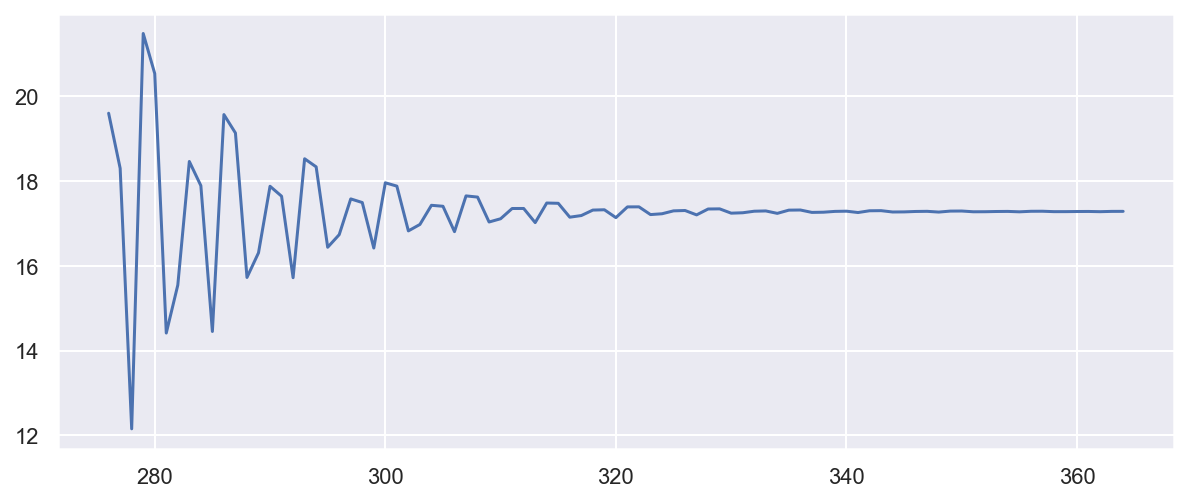

In [459]:
#Plot the pattern of the predictions
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(predictions)

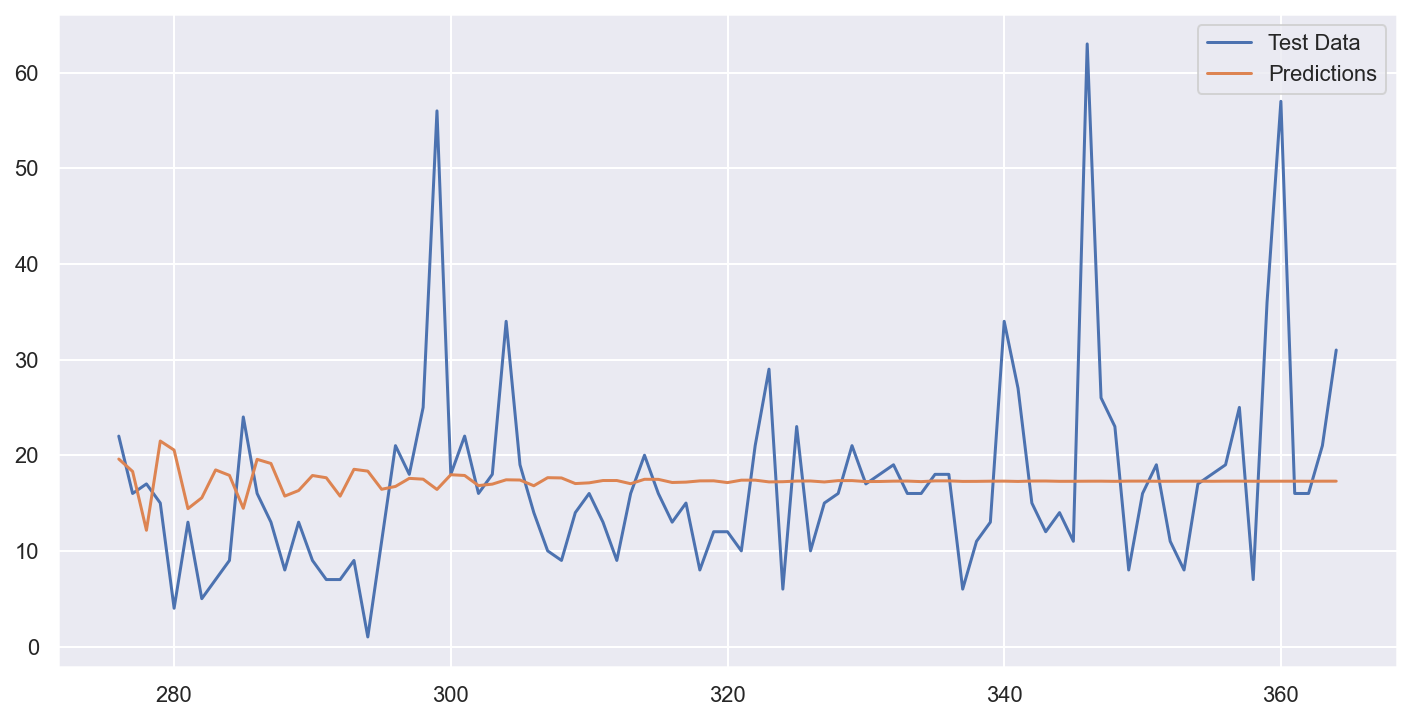

In [460]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

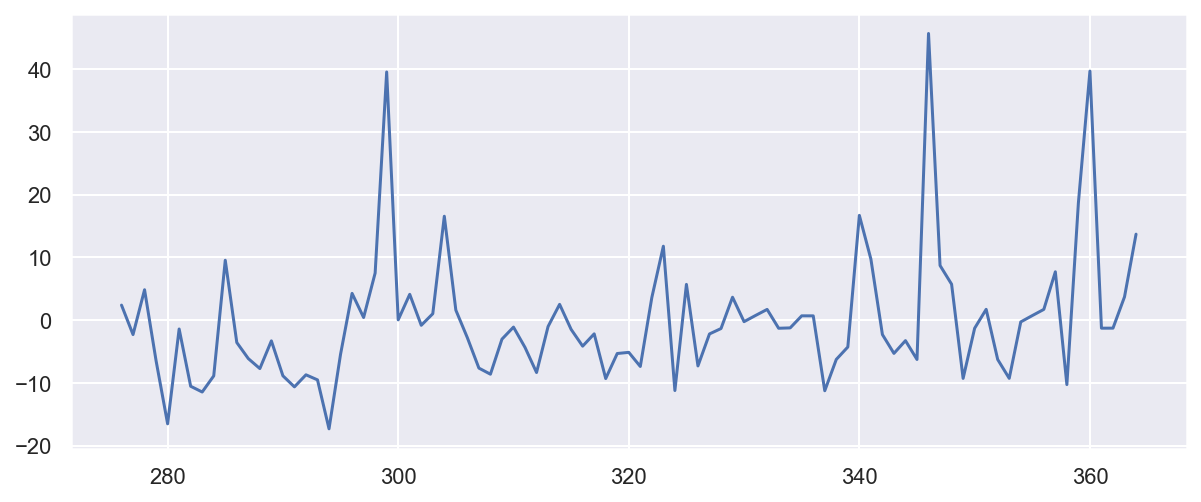

In [461]:
#Plot the pattern of the residuals
plt.figure(figsize=(10,4))
sns.set(font_scale=1)
plt.plot(residuals)

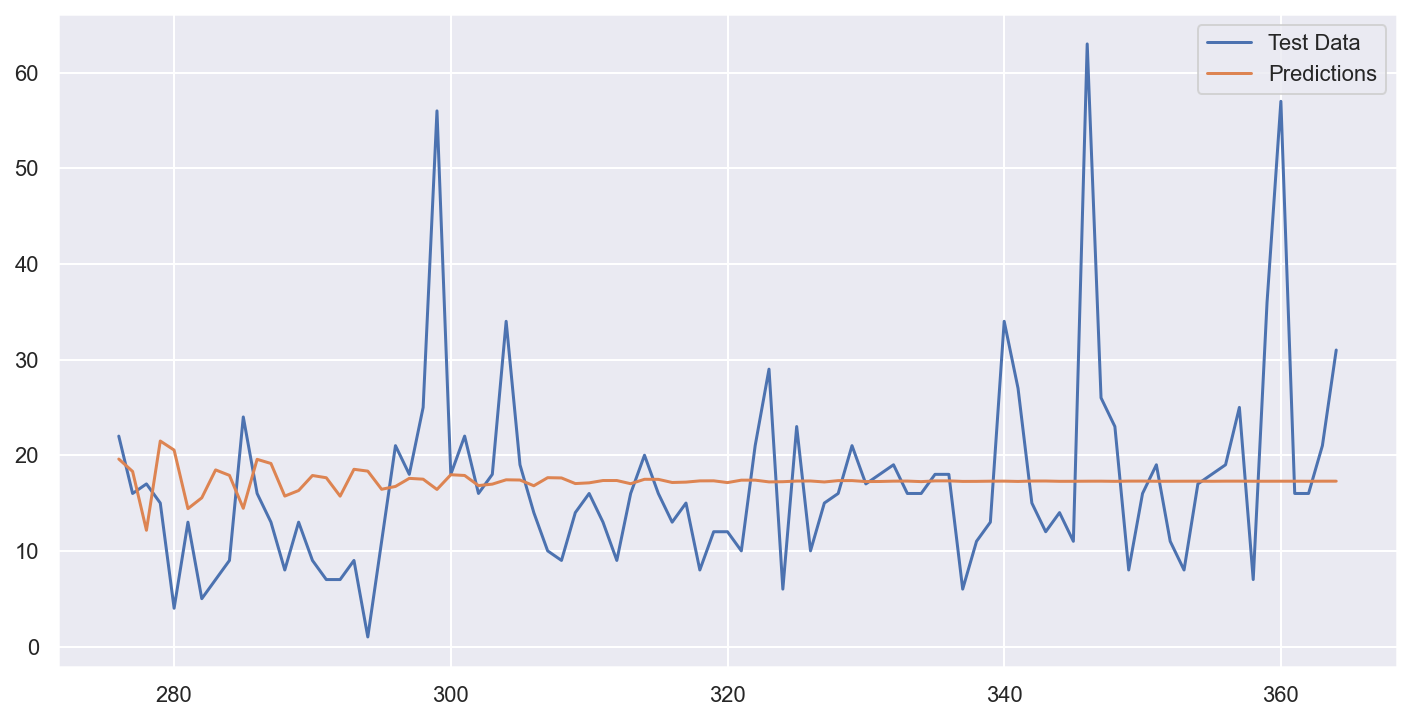

In [462]:
#Plot the graph of the Test Data vs Predictions 
plt.figure(figsize=(12,6))
#sns.set(font_scale=1)

plt.plot(test)
plt.plot(predictions)
plt.legend(('Test Data','Predictions'))

In [463]:
#Calculate Root Mean Squared error
print(f'Root Mean Squared error is: {round(np.sqrt(np.mean(residuals**2)),2)}')

Root Mean Squared error is: 10.46


In [464]:
predictions

276    19.602958
277    18.303158
278    12.153636
279    21.484874
280    20.538536
281    14.414444
282    15.546912
283    18.464174
284    17.893117
285    14.451387
286    19.570560
287    19.135977
288    15.726366
289    16.308539
290    17.879067
291    17.644283
292    15.720428
293    18.528053
294    18.337194
295    16.438832
296    16.736838
297    17.580592
298    17.495134
299    16.421045
300    17.960468
301    17.882507
302    16.825530
303    16.977329
304    17.429626
305    17.406651
306    16.807702
307    17.651534
308    17.623811
309    17.035287
310    17.112171
311    17.354048
312    17.354617
313    17.021014
314    17.483431
315    17.476690
316    17.148991
317    17.187672
318    17.316688
319    17.324249
320    17.138654
321    17.391987
322    17.393056
323    17.210583
324    17.229888
325    17.298513
326    17.306645
327    17.203511
328    17.342260
329    17.345531
330    17.243921
331    17.253463
332    17.289853
333    17.296502
334    17.2392

In [465]:
bla

NameError: name 'bla' is not defined

### Predictions

In [466]:
#predictions for positive sentiment

#copy pos df
arima = pos.copy()

#Drop date column 
arima.drop(['date'], axis=1,inplace=True)


#Set the size of the training data and test data. 
train = arima[0:365]

#Convert dataframes to a series  
train = train.squeeze()

model = ARIMA(train, order=(7,1,0))


#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())

                               SARIMAX Results                                
Dep. Variable:               positive   No. Observations:                  365
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -2493.196
Date:                Sat, 13 May 2023   AIC                           5002.392
Time:                        19:36:02   BIC                           5033.569
Sample:                             0   HQIC                          5014.783
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7421      0.037    -19.857      0.000      -0.815      -0.669
ar.L2         -0.6857      0.082     -8.316      0.000      -0.847      -0.524
ar.L3         -0.6339      0.091     -6.966      0.0

In [467]:
predictionStart = 366
predictionEnd = 455

#Call the model to make predictions
positive_predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

In [468]:
positive_predictions

366    31.747070
367    43.849275
368    20.916346
369    20.669968
370    23.140864
371    28.883516
372    21.199236
373    29.324203
374    36.360174
375    23.545871
376    23.271570
377    24.471053
378    27.758020
379    23.623750
380    28.024903
381    32.109293
382    24.950205
383    24.720088
384    25.288559
385    27.164076
386    24.946045
387    27.328989
388    29.696697
389    25.697785
390    25.525938
391    25.786446
392    26.853418
393    25.667105
394    26.956753
395    28.327557
396    26.094287
397    25.973882
398    26.087378
399    26.692637
400    26.060277
401    26.757944
402    27.550648
403    26.303698
404    26.222665
405    26.268090
406    26.610485
407    26.274661
408    26.651934
409    27.109838
410    26.413759
411    26.360715
412    26.376004
413    26.569173
414    26.391567
415    26.595509
416    26.859751
417    26.471276
418    26.437249
419    26.440132
420    26.548822
421    26.455328
422    26.565537
423    26.717880
424    26.5011

In [469]:
#predictions for negative sentiment

#copy pos df
arima = neg.copy()

#Drop date column 
arima.drop(['date'], axis=1,inplace=True)


#Set the size of the training data and test data. 
train = arima[0:365]

#Convert dataframes to a series  
train = train.squeeze()

model = ARIMA(train, order=(7,1,0))


#Estimate the model parameters 
modelFit = model.fit()

#Print Model Results
print(modelFit.summary())

                               SARIMAX Results                                
Dep. Variable:               negative   No. Observations:                  365
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -2396.977
Date:                Sat, 13 May 2023   AIC                           4809.954
Time:                        19:36:02   BIC                           4841.131
Sample:                             0   HQIC                          4822.345
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7728      0.044    -17.760      0.000      -0.858      -0.687
ar.L2         -0.7216      0.073     -9.828      0.000      -0.866      -0.578
ar.L3         -0.6816      0.083     -8.164      0.0

In [470]:
predictionStart = 366
predictionEnd = 455

#Call the model to make predictions
negative_predictions = modelFit.predict(start=predictionStart, end=predictionEnd)

In [471]:
negative_predictions

366     8.367538
367     9.834790
368    10.408413
369     5.627671
370     4.946499
371     4.341217
372     4.088572
373     7.605180
374     8.538405
375     8.852471
376     5.992897
377     5.535484
378     5.169548
379     5.074368
380     7.154853
381     7.745150
382     7.915810
383     6.205011
384     5.901522
385     5.680546
386     5.656393
387     6.888398
388     7.260015
389     7.351904
390     6.328157
391     6.128757
392     5.995461
393     6.000233
394     6.730476
395     6.963462
396     7.012383
397     6.399629
398     6.269679
399     6.189352
400     6.203483
401     6.636721
402     6.782267
403     6.807943
404     6.441098
405     6.356989
406     6.308625
407     6.323699
408     6.580968
409     6.671603
410     6.684831
411     6.465154
412     6.411033
413     6.381938
414     6.394845
415     6.547759
416     6.604040
417     6.610687
418     6.479104
419     6.444457
420     6.426968
421     6.436975
422     6.527946
423     6.562807
424     6.5660

In [472]:
#Rename colunms to something more meaningful for merge
pos = pos.rename(columns={'sentiment': 'positive' }) 
neg = neg.rename(columns={'sentiment': 'negative' }) 

In [473]:
#Create DF with dates for 2017 that we will predict
date_rng = pd.date_range('2017-01-01', periods=90, freq='D')
new_dates = pd.DataFrame({ 'date': date_rng }) 


In [474]:
#merge positive and negative dataframes
sentiment = pd.merge(pos,neg,how='left')

In [475]:
#Add futerdates to dataframe
sentiment = pd.concat([sentiment,new_dates],axis=0, join='outer')

In [476]:
#reset index to be sequence
sentiment.reset_index(drop=True, inplace=True)


In [477]:
#Insert the forcasted values to the end of the dataframe
for i in range (366, 456):    
    sentiment.iat[i,1] = positive_predictions[i]
    
for i in range (366, 456):    
    sentiment.iat[i,2] = negative_predictions[i]

In [478]:
sentiment

,date,positive,negative
0,2016-01-01,7.000000,2.000000
1,2016-01-02,20.000000,12.000000
2,2016-01-03,10.000000,5.000000
3,2016-01-04,9.000000,9.000000
4,2016-01-05,3.000000,4.000000
5,2016-01-06,18.000000,5.000000
6,2016-01-07,12.000000,7.000000
7,2016-01-08,18.000000,4.000000
8,2016-01-09,13.000000,4.000000
9,2016-01-10,4.000000,3.000000


In [479]:
bla

NameError: name 'bla' is not defined

In [ ]:
#Date conversion section

#Add a month value to the dataframe
x['year'] = x['date'].dt.year

#Add a month value to the dataframe
x['month'] = x['date'].dt.month